---
title: "[stock prediction] 1.2 머신러닝 모델 비교"
author: "agsu"
date: "7/08/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock2.png
---

# 1. baseline model  
## 1.2 머신러닝 모델 비교 

이전 글 ([1.1. 머신러닝을 위한 주가 데이터셋 생성](https://ag-su.github.io/blog/posts/01.stock_dataset.html)) 에서는 머신러닝을 위한 시계열 구조의 데이터셋을 생성했다. 이번 글에서는 생성한 데이터셋을 사용하여 머신러닝 모델을 학습하고, 평가지표를 통해 여러 모델의 성능을 비교하여 가장 좋은 성능을 보이는 모델을 선택한다. 이를 통해 생성한 기본 시계열 데이터셋을 머신러닝 알고리즘으로 학습시켰을 때, 최소한의 성능과 수익률이 발생하는지 확인할 수 있고, 이를 통해 `baseline model`을 정의한다. 

<br>

### 목차 
- (1) 데이터 불러오기 
- (2) 주가 예측 머신러닝 모델 학습  
- (3) 평가지표 시각화를 통한 모델 평가 
- (4) 모델 선택 

<br>

### 필요 라이브러리 import 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import FinanceDataReader as fdr
import pymysql

import warnings
warnings.filterwarnings('ignore')

<br>
<br>

## 주가 예측 머신러닝 모델 비교

### (1) 데이터 불러오기

지난 글에서 생성한 데이터셋을 불러온다. `train`은 2018.01.02 ~ 2020.12.31, `test`는 2021.01.02 ~ 2021.06.31 설정한 데이터셋이다.

- `train dataset` 

In [2]:
#collapse-hide
IF=open("assignment3_sql.txt",'r')
lst_code_date=[]
trainX=[]
trainY=[]
for line in IF:
    code, date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date])
    trainX.append(list(map(int, x.split(","))))
    trainY.append(int(y))
trainX=pd.DataFrame(trainX)
trainY=pd.DataFrame(trainY)

- `test dataset` 

In [3]:
#collapse-hide
IF=open("assignment3_sql_test.txt",'r')
lst_code_date_test=[]
testX=[]
testY=[]
for line in IF:
    code, date, x, y = line.strip().split("\t")
    lst_code_date_test.append([code, date])
    testX.append(list(map(int, x.split(","))))
    testY.append(int(y))
testX=pd.DataFrame(testX)
testY=pd.DataFrame(testY)

- `shape` 확인 

In [4]:
print("train dataset: ", trainX.shape, trainY.shape)
print("test dataset: ", testX.shape, testY.shape)

train dataset:  (11935, 50) (11935, 1)
test dataset:  (4431, 50) (4431, 1)


<br>
<br>

### (2) 주가 예측 머신러닝 모델 학습

앞서 불러온 주가 데이터셋으로 여러 개의 머신러닝 모델을 학습한다. 모델은 총 9개의 분류 알고리즘을 사용하여 비교한다. 

<br>

__model list__ 
- Logistic Regression
- Decision tree
- Support vector machine
- Gaussian naive bayes
- K nearest neighbor
- Random forest
- Gradient boosing
- Neural network
- XGBoost 

<br>

- 모델학습 

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import time

results=[]

##### 1. Logistic regression    
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(trainX, trainY)

##### 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(trainX, trainY)

##### 3. Support vector machine
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(trainX, trainY)

##### 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(trainX, trainY)

##### 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(trainX, trainY)

##### 6. Random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(trainX, trainY)

##### 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(trainX, trainY)

##### 8. Neural network
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000)
mlp.fit(trainX, trainY)

##### XGBoost 
from xgboost import XGBClassifier
xgb = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=500,
                   ) 

xgb.fit(trainX, trainY)

[00:14:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

-  예측  

학습시킨 모델 별로 Accuracy와 AUC score를 측정하여, `lst_result_acc`, `lst_result_roc` 리스트에 추가한다. 

In [6]:
lst_model = [lr, dt, svc, gnb, knn, rf, gb, mlp, xgb]

dic_model2name = {lr:'LogisticRegression', dt:'DecisionTree', svc:'SVM', 
                  gnb:'GaussianNaiveBayes', knn:'KNN', rf:'RandomForest', 
                  gb:'GradientBoosting', mlp:'NeuralNetwork', xgb:'XGBoost'}

lst_result_acc = [] # [['모델명', train 평가지표, test 평가지표], ...]
lst_result_roc = []

for model in lst_model: 
    # accuracy 
    predY_train = model.predict(trainX)
    predY_test = model.predict(testX)
    
    accuracy_train = accuracy_score(trainY, predY_train)
    accuracy_test = accuracy_score(testY, predY_test)

    # auc score 
    probY_train = model.predict_proba(trainX)[:, 1]
    probY_test = model.predict_proba(testX)[:, 1]
    
    roc_score_train = roc_auc_score(trainY, probY_train)
    roc_score_test = roc_auc_score(testY, probY_test)
    
    # 리스트에 추가 
    lst_result_acc.append([dic_model2name[model], accuracy_train, accuracy_test])
    lst_result_roc.append([dic_model2name[model], roc_score_train, roc_score_test])
    
print('accuracy list: ', lst_result_acc[:2])
print()
print('auc score list: ', lst_result_roc[:2])

accuracy list:  [['LogisticRegression', 0.7622957687473817, 0.7734145791017829], ['DecisionTree', 1.0, 0.598059128864816]]

auc score list:  [['LogisticRegression', 0.5318105913341066, 0.5430800870053489], ['DecisionTree', 1.0, 0.4824088530616373]]


<br>
<br>

### (3) 평가지표 시각화를 통한 모델 평가

위에서 얻은 9가지 모델의 평가 지표(`accuracy`, `auc score`) 결과 리스트를 받아 모델 별로 평가지표를 비교하는 `bar graph` 시각화 함수를 작성한다.  
`test` 데이터셋의 성능이 높은 순서대로 정렬하여 시각화한다. 

In [10]:
def result_plot(lst:list, index:str): 
    '''
    lst: [['모델명', 'train 평가지표', 'test 평가지표'], ...]
    index: 'acc' or 'auc'
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    if index == 'acc': 
        plt.figure(figsize=(12, 5))  
        plt.title("ACCURACY", fontsize=20)
        
        df = pd.DataFrame(data=lst_result_acc, 
                     columns=['name', 'train', 'test']).set_index('name')
        
        df_results = df.reset_index().melt(id_vars='name')
      
    elif index == 'auc': 
        plt.figure(figsize=(12, 5))  
        plt.title("ROCAUC", fontsize=20)
        df = pd.DataFrame(data=lst_result_roc, 
                     columns=['name', 'train', 'test']).set_index('name')
        df_results = df.reset_index().melt(id_vars='name')
        
    else:
        print("평가지표를 다시 입력해주세요.")
        
      
    ax = sns.barplot(x="name", y="value", hue='variable', data=df_results, capsize=.2, 
                     order=df['test'].sort_values(ascending=False).index)
    ax.set(ylim=(0.00, 1.1))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=60) 
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01, round(height, 2), ha = 'center', size = 10)

    plt.show()

**`Accuracy`**

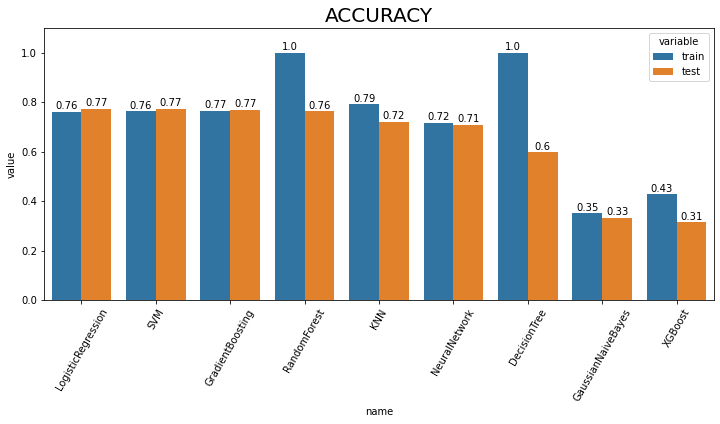

In [11]:
result_plot(lst_result_acc, 'acc')

**`AUROC`**

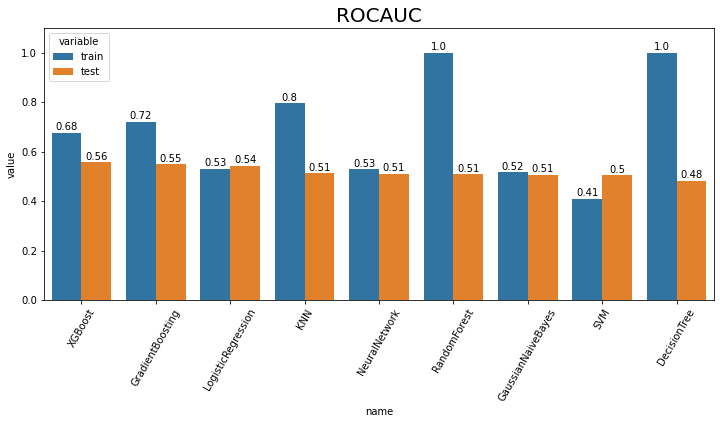

In [12]:
result_plot(lst_result_acc, 'auc')

Accuracy는 Logistic Regression, ROCAUC는 XGBoost가 가장 높은 값을 얻은 것을 확인하였다. 

<br>
<br>

### (4) 모델 선택 

- **1) 선택 기준 평가지표 선택 - 종속변수 불균형 문제**  

모델 선택을 위해 사용할 평가지표를 선택한다.

===============train===============
0의 비율:  0.7622957687473817
1의 비율:  0.23770423125261836

===============test================
0의 비율:  0.7734145791017829
1의 비율:  0.2265854208982171



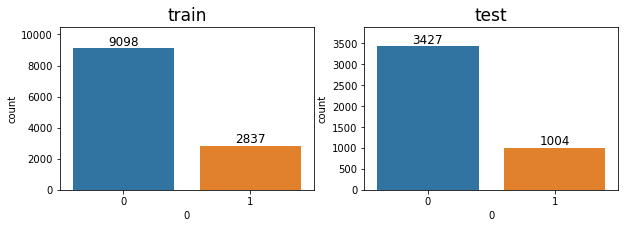

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 3))
ax1, ax2 = fig.subplots(1, 2).flatten()

# countplot 시각화
sns.countplot(data=trainY, x=0, ax=ax1)
sns.countplot(data=testY, x=0, ax=ax2)

# title 설정
ax1.set_title("train", fontsize=17)
ax2.set_title("test", fontsize=17)

# ylim 설정
ax1.set_ylim(0, 10500)
ax2.set_ylim(0, 3900)

# text 추가
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2., height + 200, height, ha = 'center', size = 12)
    
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2., height + 80, height, ha = 'center', size = 12)

# class 0, 1 비율 계산
print("===============train===============")
print("0의 비율: ", sum(trainY[0] == 0) / (sum(trainY[0]==0) + sum(trainY[0]==1)))
print("1의 비율: ", sum(trainY[0] == 1) / (sum(trainY[0]==0) + sum(trainY[0]==1)))
print()
print("===============test================")
print("0의 비율: ", sum(testY[0] == 0) / (sum(testY[0]==0) + sum(testY[0]==1)))
print("1의 비율: ", sum(testY[0] == 1) / (sum(testY[0]==0) + sum(testY[0]==1)))
print()

이진분류 된 종속변수를 `countplot`으로 시각화하여 분포를 살펴보았을 때, 종속변수가 0인 데이터의 비율이 높은 것을 확인할 수 있습니다. 이는 모델이 모두 0이라고 예측해도 정확도가 76~77%가 나온다는 뜻이다. 따라서 정확도는 해당 주가 데이터를 평가하기 위한 지표로는 신뢰성이 떨어진다고 판단되어, `threshold`별 `score`가 결정되는 `ROCAUC score`를 기준으로 모델을 선택한다. 

<br>

- **2) 예측 신뢰성**

`test dataset`의 `AUC`가 높은 상위 2개 모델(`XGBoost`, `GradientBoosting`)의 예측 확률을 살펴본다.

In [15]:
xgb_prob = xgb.predict_proba(testX)[:, 1] 
gb_prob = gb.predict_proba(testX)[:, 1]

print('XGB:', sum(xgb_prob >= 0.6), '개')
print('GB:', sum(gb_prob >= 0.6), '개')

XGB: 1268 개
GB: 1 개


`class`를 `1`로 예측할 확률이 `60%` 이상인 데이터의 개수를 확인해보면, `XGBoost`는 `1268`개, `GradientBoosting`은 `1`개가 나온다. 

-------------

**1)**, **2)** 를 근거로 하여 여러 머신러닝 모델 중 `AUC` 점수 1위인 동시에, 예측 신뢰성이 더 높다고 판단되는 **`XGBoost`** 를 최종적으로 `baseline` 머신러닝 모델로 결정합니다.

<br>
<br>

### baseline 모델 정리 및 수익률 측정

**baseline 모델 정리**  

- **데이터**   
    - 종목: kospi + kosdaq 주식 시장 3년 이상 존속하였던 종목들
    - 기간: 2018.01.01-2020.12.31 (총 3년) 
    - 필터링: 거래대금 1000억 이상 
    - 구조: 10일 간의 데이터들을 feature로 두어 시계열 데이터셋 생성


- **모델**  
XGBClassifier(  
                n_jobs=40,  
                scale_pos_weight=4,  
                learning_rate=0.01,  
                max_depth=3,  
                n_estimators=500,  
                ) 


**수익률 측정**  
baseline모델을 선정하였으므로 프로젝트에서 중요한 부분인 수익률 측정을 수행한다. 

In [17]:
print('XGB:', sum(xgb_prob >= 0.65), '개')

XGB: 34 개


해당 수익률 계산 시뮬레이션에서는 prob 임계값을 0.65로 설정함으로써 6개월 동안 1~2주에 한번 꼴로 매매가 이루어지도록 하였다. 

In [45]:
def compute_earnings_rate(lst_code_date, probY):
    ##### DB 
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = '[db username]', 
        passwd = '[db password]', 
        db = '[db name]', 
        charset = 'utf8'
    )
    
    cursor = db_dsml.cursor()
    
    ##### 주문 일지 작성 #####
    lst_output=[]
    for (code, date), y in zip(lst_code_date, probY):
        if y >= 0.65: # 예측 확률 (probY) 임계값 0.65 
            lst_output.append([code, date, "buy", "all"])  
            lst_output.append([code, date+"n", "sell", "all"])  
            
    lst_output.sort(key=lambda x:x[1]) # 날짜로 정렬 
    
    
    ##### 수익률 계산 #####
    start_money = 10000000 # 초기 현금 1천만원
    money = start_money
    dic_code2num ={}  # 보유 종목
    
    for i, row in enumerate(tqdm(lst_output)): # 주문 일지를 한 줄 읽어 옴
        code, date, request, amount = row

        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2021-01-01' AND '2021-06-31'
                    '''.format(code)
        stock = pd.read_sql(sql = sql_query, con = db_dsml)
        lst_data = stock.values.tolist()    

        
        for idx, row in enumerate(lst_data):
            data_date = row[0].date().strftime('%Y%m%d')

            if 'n' in date: # 매도 날짜
                date_n = date[:-1]
                if data_date == date_n: 
                    close = lst_data[idx+1][-3] # 매도 할 종가 (매수 다음날 종가)
                    break            

            else: # 매수 날짜 
                if data_date == date:
                    close = row[-3] # 매수 할 종가 
                    break
        
        if request == 'buy': # 매수 
            if amount.startswith('r'): # 분할 매수 시 사용 
                request_money = money * float(amount.lstrip("r")) / 100
            elif amount == 'all':
                request_money = money
            elif amount.isdigit():
                request_money = int(amount)
            else:
                raise Exception('Not permitted option')
                
            request_money = min(request_money, money)
            
            buy_num = int(request_money / close) # 매수 개수 
            
            money -= buy_num * close  # 매수 후 잔고 업데이트 
            
            if code not in dic_code2num: # 현재 보유종목이 아니라면 
                dic_code2num[code] = 0 # dict에 key 생성 
                
            dic_code2num[code] += buy_num # 해당 종목의 보유 개수 업데이트
            
        if request == 'sell': # 매도 
            if amount == 'all':   
                sell_num = dic_code2num[code] # 해당 종목의 보유하고 있는 모든 개수 매도
            else:
                raise Exception('Not permitted option')       
                
            money += sell_num * close # 매도 후 잔고 업데이트 
            
            dic_code2num[code] -= sell_num # 해당 종목 매도 후 보유 개수 업데이트 
            if dic_code2num[code] == 0: # 해당 종목이 보유하고 있는 개수가 없다면 
                del dic_code2num[code] # 보유종목에서 삭제 

    if dic_code2num != {}: # 주문일지를 모두 돌고난 후에는 보유종목 dict가 비어있어야 함. 
        raise Exception('Not empty stock') 

    print("Final earning rate : {} %".format(str((money-start_money) / start_money * 100)))
#     return str((money-start_money) / start_money * 100)

In [46]:
compute_earnings_rate(lst_code_date_test, xgb_prob)

100%|█████████████████████████████████████████████| 68/68 [00:00<00:00, 265.33it/s]

Final earning rate : 54.73516000000001 %


최종적으로 baseline 모델의 수익률을 계산해봤을 때, 6개월간의 총 수익률은 약 54%가 나왔다. 평가지표인 ROCAUC score는 낮은 편에 속했지만, 높은 수익률을 보였다.   
다음 글 부터는 `data preprocessing`을 진행하며, 주가 빅데이터의 질을 높여  baseline model 보다 뛰어난 성능을 보이도록 개선한다. 